Using cpu device
Starting training...
Logging to E:/project\outputs\logs\dqn_best_hyperparameters\DQN_3
Eval num_timesteps=2000, episode_reward=-0.00 +/- 0.00
Episode length: 182.00 +/- 0.00
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 182       |
|    mean_reward      | -1.82e-11 |
| rollout/            |           |
|    exploration_rate | 0.505     |
| time/               |           |
|    total_timesteps  | 2000      |
-----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 856      |
|    ep_rew_mean      | 0.144    |
|    exploration_rate | 0.153    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1405     |
|    time_elapsed     | 2        |
|    total_timesteps  | 3424     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.000298 |
|    n_u

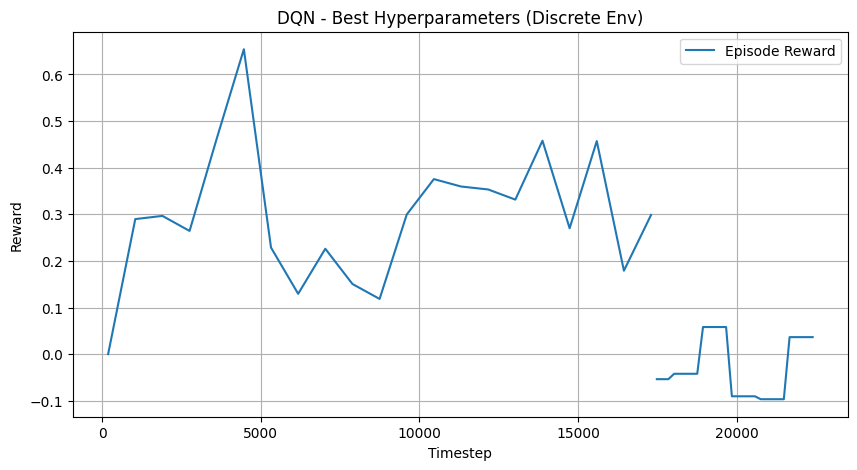

In [3]:
# final dqn train compateble with SB3 che with output : 
# .zip file bayni che \models\dqn_discrete_lr1e4\ ma: 
import os, sys, numpy as np, matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.env_util import make_vec_env

PROJECT_ROOT = r"E:/project"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from envs.trading_env_discrete import TradingEnvDiscrete

# Paths
DATA_PATH = os.path.join(PROJECT_ROOT, "outputs", "datasets", "states_v1_single_asset.npz")
SAVE_DIR  = os.path.join(PROJECT_ROOT, "outputs", "models", "dqn_best_hyperparameters")
LOG_DIR   = os.path.join(PROJECT_ROOT, "outputs", "logs", "dqn_best_hyperparameters")
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# Load data
data = np.load(DATA_PATH)
X_train, X_val = data["X_train"], data["X_val"]
prices = data["prices"]
prices_train = prices[:len(X_train)]
prices_val   = prices[len(X_train):len(X_train)+len(X_val)]

# Make vec envs (NO Monitor here)
def make_train():
    return TradingEnvDiscrete(X_train, prices_train, reward_type="log_return")

def make_val():
    return TradingEnvDiscrete(X_val, prices_val, reward_type="log_return")

train_env = make_vec_env(make_train, n_envs=1, seed=42, vec_env_cls=DummyVecEnv)
val_env   = make_vec_env(make_val,   n_envs=1, seed=43, vec_env_cls=DummyVecEnv)

# Wrap with VecMonitor to record monitor.csv correctly
train_env = VecMonitor(train_env, LOG_DIR)
val_env   = VecMonitor(val_env,   LOG_DIR)

# Callback
eval_callback = EvalCallback(
    val_env,
    best_model_save_path=SAVE_DIR,
    log_path=LOG_DIR,
    eval_freq=2000,
    deterministic=True,
    render=False
)


# Train DQN agent 
# Best hyper parameters for DQN : 
model = DQN(
    "MlpPolicy",
    train_env,
    learning_rate=5e-4,        # smaller LR for stability
    buffer_size=100000,        # larger replay buffer
    learning_starts=2000,      # let agent explore before training
    batch_size=64,             # bigger batches smooth learning
    gamma=0.99,                # discount factor (standard)
    tau=1.0,                   # target network update coeff
    train_freq=4,              # update every 4 steps
    target_update_interval=1000,
    exploration_fraction=0.2,  # more exploration initially
    exploration_final_eps=0.01,# lower epsilon floor
    verbose=1,
    tensorboard_log=LOG_DIR
)


print("Starting training...")
model.learn(total_timesteps=20000, callback=eval_callback)
model.save(os.path.join(SAVE_DIR, "dqn_final"))
print(f"Training done. Model saved to {SAVE_DIR}")

# Plot Training Rewards

results_file = os.path.join(LOG_DIR, "monitor.csv")
if os.path.exists(results_file):
    # SB3 monitor.csv has comment lines starting with '#'
    df = pd.read_csv(results_file, skiprows=1, comment="#", on_bad_lines="skip") # fixed bad columns
    # df contains columns like "r", "l", "t"
    timesteps = df["l"].cumsum()   # episode lengths → cumulative timesteps
    rewards = df["r"]              # episode rewards

    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, rewards, label="Episode Reward")
    plt.xlabel("Timestep")
    plt.ylabel("Reward")
    plt.title("DQN - Best Hyperparameters (Discrete Env)")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(LOG_DIR, "dqn_best_hyperparameters_training_rewards.png")
    plt.savefig(plot_path, dpi=150, bbox_inches="tight")
    print(f"Training reward plot saved to {plot_path}")
else:
    print("Warning: monitor.csv not found, no reward plot generated.")
 